In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import lambeq as lq
from lambeq.pregroups import remove_cups
from lambeq import AtomicType, IQPAnsatz, BobcatParser
import pennylane as qml
from discopy import grammar, Circuit, Swap, H, Measure

from discopy import grammar
from discopy.grammar import Word
from discopy.rigid import Cap, Cup, Id, Ty
import torch
import random

from sentence_transformers import SentenceTransformer
from lambeq import PennyLaneModel
from lambeq import Dataset
from lambeq import PytorchTrainer

# Sadrzadeh-Kartsaklis-Transitive WordData Import

In [8]:
# read the text file into a pandas dataframe
#df = pd.read_csv('Sadrzadeh-Kartsaklis-TransativeWordData.txt', sep=' ')
df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')

# assign column names to the dataframe
df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']

# group the data by the three sentence columns and calculate the mean and standard deviation of the score column
grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()

# flatten the multi-level column names of the grouped data
grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]

# rename the mean and std columns to 'score' and 'range' respectively
grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()

unique_word_list = []
for ind, row in grouped_data.iterrows():
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
grouped_data.describe()

,score,range
count,108.000000,108.000000
mean,0.372650,0.923883
std,0.230505,0.538162
min,0.162338,0.000000
25%,0.187923,0.495386
50%,0.269481,0.972611
75%,0.514069,1.348797
max,1.000000,1.929594


In [9]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range
0,agent,sell,property,family,buy,home,0.507305,1.541104
1,agent,sell,property,group,hold,meeting,0.189394,0.481543
2,author,write,book,delegate,buy,land,0.183512,0.625543
3,author,write,book,man,hear,word,0.266234,1.036018
4,author,write,book,writer,read,word,0.514069,1.090140
...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427
104,woman,drink,water,system,use,method,0.175866,0.408248
105,worker,join,party,employee,leave,company,0.227273,0.577350
106,writer,read,word,family,receive,letter,0.339433,1.341963


In [10]:
len(grouped_data['subject1'].unique()), len(grouped_data['verb1'].unique()), len(grouped_data['object1'].unique()), len(grouped_data['subject2'].unique()), len(grouped_data['verb2'].unique()), len(grouped_data['object2'].unique())

(55, 59, 61, 51, 56, 60)

# Sentance Embeddings

In [11]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

SENT_similarities_subject = []

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	#sent1_embeddings = sent1_embeddings /  sent1_embeddings.max()
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	sent2_embeddings = embedder.encode(sent2)
	#sent2_embeddings = sent2_embeddings /  sent2_embeddings.max()
	SENT_similarities_subject.append(1-cosine(sent1_embeddings, sent2_embeddings))

grouped_data['SENT_sent_sim'] = SENT_similarities_subject
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim
score,1.000000,0.858698,0.797066
range,0.858698,1.000000,0.598361
SENT_sent_sim,0.797066,0.598361,1.000000


(0.1, 1.1)

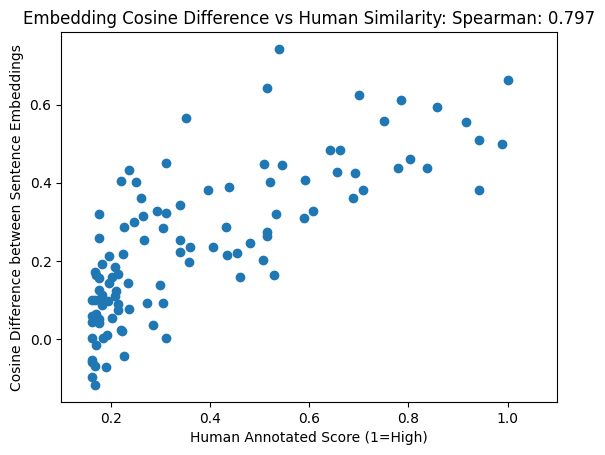

In [12]:
plt.scatter(grouped_data['score'], grouped_data['SENT_sent_sim'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['SENT_sent_sim'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

# Word Embeddings with Sentence Embedder

In [13]:
BERT_similarities_subject,BERT_similarities_verb,BERT_similarities_obj   = [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		rows_embeddings.append(embedder.encode(i))
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0] ,rows_embeddings[3]))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1] , rows_embeddings[4]))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2] , rows_embeddings[5]))

grouped_data['SENT_sub_sim'] = BERT_similarities_subject
grouped_data['SENT_verb_sim'] = BERT_similarities_verb
grouped_data['SENT_obj_sim'] = BERT_similarities_obj
grouped_data['ave'] = (grouped_data['SENT_obj_sim'] +grouped_data['SENT_verb_sim'] +grouped_data['SENT_sub_sim'])/3
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000


(0.1, 1.1)

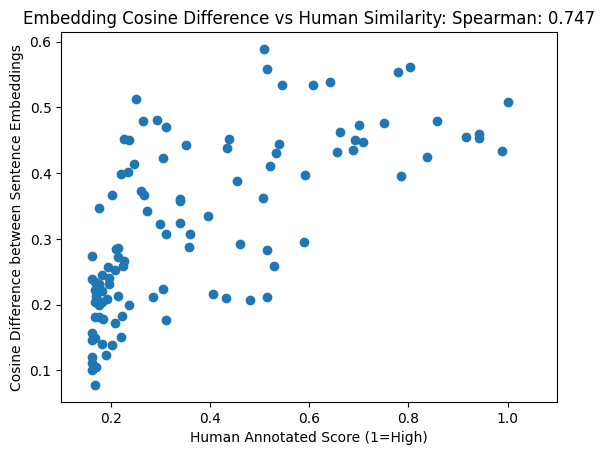

In [14]:
plt.scatter(grouped_data['score'], grouped_data['ave'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['ave'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

Text(0.5, 1.0, 'SquaredError between sum of word encodings and sentence (mean = 0.112)')

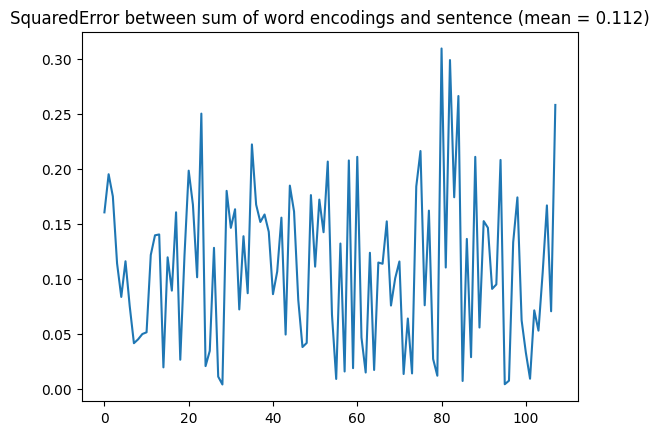

In [15]:
plt.plot(np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2))
plt.title("SquaredError between sum of word encodings and sentence (mean = "+str(np.round(
np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2).mean(), 3))+")")

# Dimension Reduction

In [16]:
def DimReduceByPCA(input_array, new_dims):
	#Pick new_dims Eigenvectors
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def DimReduceBySVD(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

def RotateWordVector(input_word_vector):
	#Define word as a similarity vector compared to all the other words in corpus
	rotated_word_vector = np.zeroes(len(unique_word_list))
	for index, comaprison_word in enumerate(unique_word_list):
		rotated_word_vector[index] = (1-cosine(input_word_vector, embedder.encode(comaprison_word)))
	return rotated_word_vector

In [17]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector

pca_dim = 10
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

Text(0, 0.5, 'Change in similarity from 384 dim to 10')

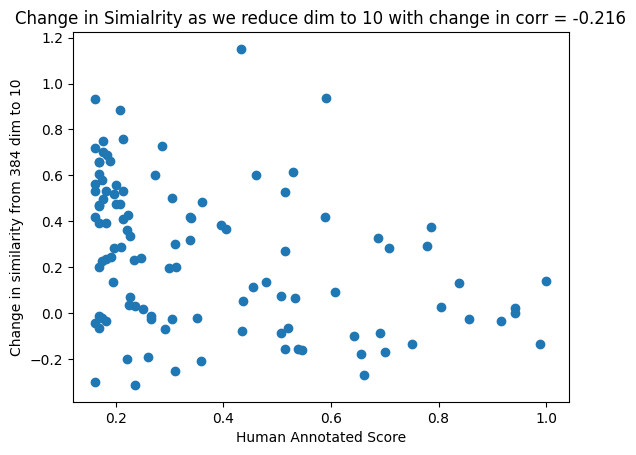

In [18]:
similarities = []
for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = word_vector_dict[row['subject1']][384] + word_vector_dict[row['verb1']][384] + word_vector_dict[row['object1']][384]
	sent2 = word_vector_dict[row['subject2']][384] + word_vector_dict[row['verb2']][384] + word_vector_dict[row['object2']][384]

	sent1_low_dim = word_vector_dict[row['subject1']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb1']]["pca_"+str(pca_dim)] + word_vector_dict[row['object1']]["pca_"+str(pca_dim)]
	sent2__low_dim = word_vector_dict[row['subject2']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb2']]["pca_"+str(pca_dim)] + word_vector_dict[row['object2']]["pca_"+str(pca_dim)]
	similarities.append([1-cosine(sent1, sent2), 1-cosine(sent1_low_dim, sent2__low_dim)])

similarities = np.array(similarities)
plt.scatter(grouped_data['score'], similarities[:,0]-similarities[:,1])
plt.title("Change in Simialrity as we reduce dim to "+str(pca_dim) +" with change in corr = "+str(
	np.round(grouped_data['score'].corr(pd.Series(similarities[:,1]), method='spearman') - grouped_data['score'].corr(pd.Series(similarities[:,0]), method='spearman'), 3)
	))
plt.xlabel("Human Annotated Score")
plt.ylabel("Change in similarity from 384 dim to "+str(pca_dim))

In [19]:
grouped_data['PCA_'+str(pca_dim)] = similarities[:,1]
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846,0.537317
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353,0.399214
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033,0.721874
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862,0.616374
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512,0.454426
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626,0.527056
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000,0.750198
PCA_10,0.537317,0.399214,0.721874,0.616374,0.454426,0.527056,0.750198,1.000000


In [20]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
0,agent,sell,property,family,buy,home,0.507305,1.541104,0.201549,0.111137,0.687575,0.287326,0.362013,0.394433
1,agent,sell,property,group,hold,meeting,0.189394,0.481543,-0.071638,0.127501,0.288967,-0.046184,0.123428,-0.419797
2,author,write,book,delegate,buy,land,0.183512,0.625543,0.003442,0.157430,0.166433,0.211330,0.178398,-0.365270
3,author,write,book,man,hear,word,0.266234,1.036018,0.252530,0.338995,0.372899,0.388278,0.366724,0.551217
4,author,write,book,writer,read,word,0.514069,1.090140,0.641656,0.755711,0.529858,0.388278,0.557949,0.978626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427,0.192133,0.172855,0.355742,0.207168,0.245255,0.427217
104,woman,drink,water,system,use,method,0.175866,0.408248,0.125207,0.107123,0.355742,0.230542,0.231135,-0.363076
105,worker,join,party,employee,leave,company,0.227273,0.577350,0.285479,0.751912,0.395919,0.208960,0.452264,0.521499
106,writer,read,word,family,receive,letter,0.339433,1.341963,0.253634,0.239393,0.252427,0.481148,0.324322,0.074801


In [21]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector

pca_dim = 2
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

pca_dim = 3
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})
		
pca_dim = 4
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

pca_dim = 6
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

In [22]:
word_vector_dict['agent']

{384: array([-0.02489181, -0.35199916, -0.38204622, ..., -0.3539789 ,
        -0.04372901,  0.0109901 ], dtype=float32),
 'pca_2': array([ 1.40708568, -1.14017986]),
 'pca_3': array([ 1.40708568, -1.14017986,  0.92208192]),
 'pca_4': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437]),
 'pca_6': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445])}

# Quantum Encoding

- Choose an Anzatz with invarient Inner Product

- Export circuit from lambeq/discopy to pennylane - possibly not

- tensor network module

- 12 qubits, 

- discopro - removing cups (kinianlo/discopro)

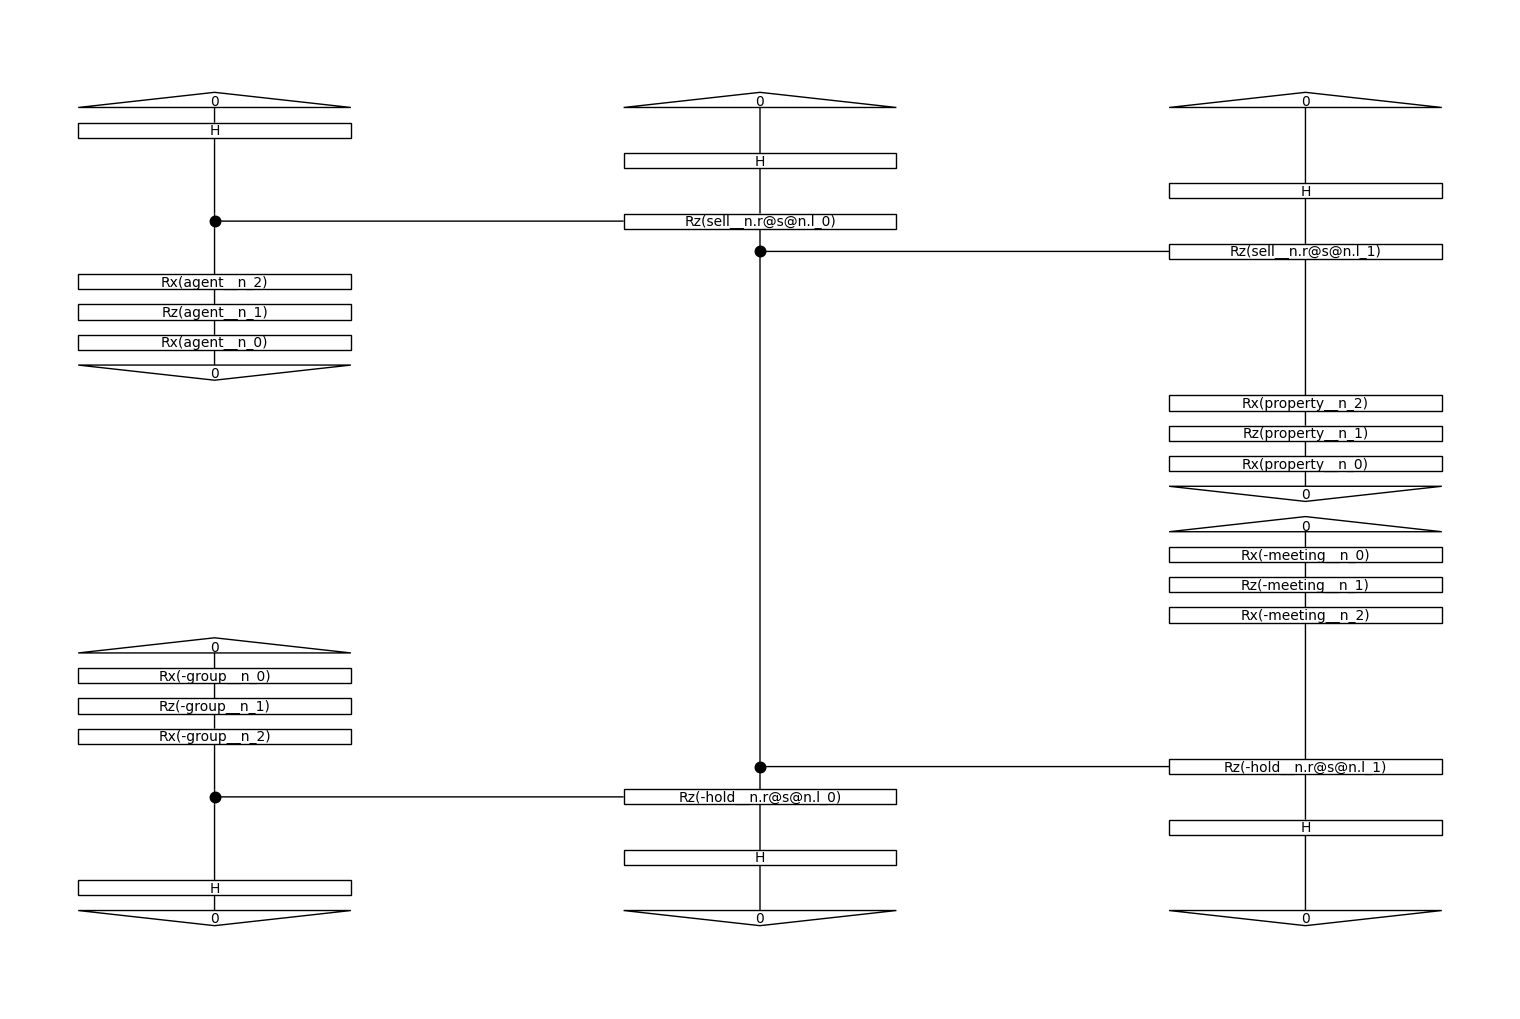

In [23]:
def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')

    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]

    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

    diagram = Id().tensor(*words) >> cups
    return diagram

def make_diagrams(data,row1, row2=None, drawing=False):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    
    diagram1 = diagram_to_sentence(sentence1.split(" "))
    diagram1 = remove_cups(diagram1)
    diagram2 = diagram_to_sentence(sentence2.split(" "))
    diagram2 = remove_cups(diagram2)
    
    if drawing:
        diagram1.draw(figsize=(14,3), fontsize=12)
    return diagram1, diagram2

def make_circuit_from_diagrams(diagram1, diagram2, vector, drawing=False, qubits_noun=1, qubits_subject=1, upload_count=1):
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE

    # Convert string diagram to quantum circuit
    ansatz = IQPAnsatz({N: qubits_noun, S: qubits_subject}, n_layers=upload_count)

    discopy_circuit1 = ansatz(diagram1)
    discopy_circuit2 = ansatz(diagram2)
    discopy_circuit2 = discopy_circuit2.dagger()

    discopy_circuit = discopy_circuit1 >> discopy_circuit2

    #Remove if neccessary...Encode vector into rotation gates
    #num_params = len(vector)
    #for i in range(num_params):
    #    qml.CNOT(wires=[i, i+1])
    #    qml.RX(vector[i][0], wires=i)

    if drawing:
        discopy_circuit.draw(figsize=(15, 10))

    pennylane_circuit = discopy_circuit.to_pennylane()

    return pennylane_circuit, discopy_circuit

def make_circuit_from_data(data, row_number):
    diagram1, diagram2 = make_diagrams(data, row_number)
    vector = [(0.1, 0.2, 0.3), (0.4, 0.5, 0.6), (0.7, 0.8, 0.9), (1.0, 1.1, 1.2)]  # Example vector
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, vector, False)
    return qml_circuit, discopy_circuit
    

make_circuit_from_data(grouped_data, 1)[1].draw(figsize=(15, 10))

In [24]:
make_circuit_from_data(grouped_data, 1)[1].free_symbols

{agent__n_0,
 agent__n_1,
 agent__n_2,
 group__n_0,
 group__n_1,
 group__n_2,
 hold__n.r@s@n.l_0,
 hold__n.r@s@n.l_1,
 meeting__n_0,
 meeting__n_1,
 meeting__n_2,
 property__n_0,
 property__n_1,
 property__n_2,
 sell__n.r@s@n.l_0,
 sell__n.r@s@n.l_1}

# Classically Simulated Quantum Model

No input of our classically learnt parameters yet, this is just an attempt to get the circuit learnt. I will overwrite the initialise_weights() function to add in the parameters in future.

In [34]:
BATCH_SIZE = 1
EPOCHS = 2000
SEED = 42

epoch_count = [i for i in range(0, EPOCHS)]

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Data

In [159]:
labels = grouped_data['score']

training = pd.read_csv("Data/TrainingData.txt")
test = pd.read_csv("Data/TestData.txt")

train_data =  [make_circuit_from_data(training, i)[1] for i in range(len(training))]
train_labels = labels[training['Unnamed: 0'].values]
val_data = [make_circuit_from_data(test, i)[1] for i in range(len(test))] 
val_labels = labels[test['Unnamed: 0'].values]

diagrams = train_data + val_data

train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

In [160]:
# Overlap of training and Test data
training_words = []
for circuit in train_data:
    for parameter in circuit.free_symbols:
        training_words.append(parameter.name.split("_")[0])
training_words = np.array(training_words)

validate_words = []
for circuit in val_data:
    for parameter in circuit.free_symbols:
        validate_words.append(parameter.name.split("_")[0])
validate_words = np.array(validate_words)

validate_words= set(np.unique(validate_words))
training_words = set(np.unique(training_words))
print("%/ of validation words in training words",  len(validate_words.intersection(training_words))/len(validate_words))

%/ of validation words in training words 0.9928571428571429


In [147]:
def free_symbols_to_rotations(symbols):
    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word = word_symbol.name.split("_")
        word_string = word[0]
        word_type = word[-2]
        if word_type == "n":
            word_dims = 3
        elif "@" in word_type:
            word_dims = 2 #Dynamically calc these later 
        word_index = int(word[-1])

        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]
    return weights
        
free_symbols_to_rotations(train_dataset[0][0].free_symbols)

array([ 0.92208192, -1.4491714 , -1.14017986,  2.3314512 ,  2.80335132,
        1.40708568,  2.65990934,  0.64036738, -0.86225161, -1.06764211,
        0.63920176,  1.68896028,  0.4315886 ,  2.38851625, -0.06792098,
       -0.91693481])

## Numpy Model

In [ ]:
from lambeq import QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss

numpy_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
mse = MSELoss()

numpy_trainer = QuantumTrainer(
    numpy_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)
numpy_trainer.fit(train_dataset, val_dataset, logging_step=100)

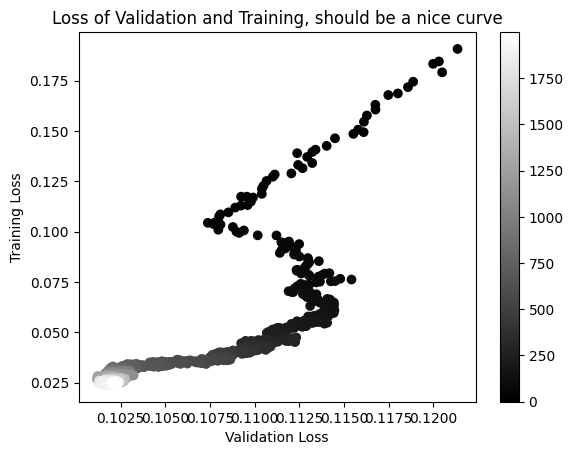

In [ ]:
plt.scatter(numpy_trainer.val_costs,numpy_trainer.train_epoch_costs,c=epoch_count, cmap='gray')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()

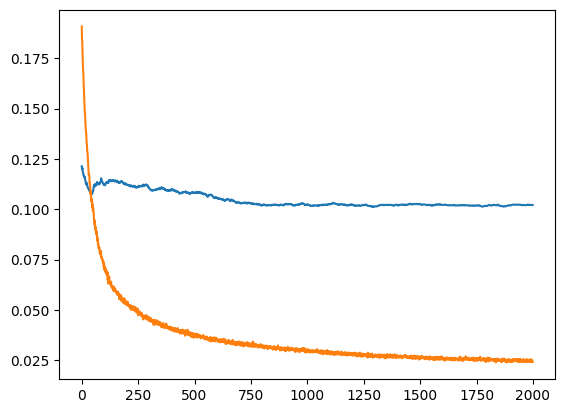

In [163]:
plt.plot(epoch_count, numpy_trainer.val_costs)
plt.plot(epoch_count, numpy_trainer.train_epoch_costs)

# Numpy Encoded Model

In [164]:
from lambeq import QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss

class QuantumEncodedNumpyModel(NumpyModel):
     def initialise_weights(self) -> None:
        """Initialise the weights of the model.

        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.

        """
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                             '`from_diagrams()`.')
        self.weights = free_symbols_to_rotations(self.symbols)
		

numpy_e_model = QuantumEncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
numpy_e_model.initialise_weights()
len(numpy_e_model.weights)

483

In [165]:
mse = MSELoss()

numpy_e_trainer = QuantumTrainer(
    numpy_e_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)
numpy_e_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:     train/loss: 0.1896   valid/loss: 0.1278   train/mse: 0.1887   valid/mse: 0.1278
Epoch 50:    train/loss: 0.1290   valid/loss: 0.1052   train/mse: 0.1288   valid/mse: 0.1052
Epoch 100:   train/loss: 0.1006   valid/loss: 0.0971   train/mse: 0.0996   valid/mse: 0.0971
Epoch 150:   train/loss: 0.0832   valid/loss: 0.0919   train/mse: 0.0804   valid/mse: 0.0919
Epoch 200:   train/loss: 0.0732   valid/loss: 0.0893   train/mse: 0.0763   valid/mse: 0.0893
Epoch 250:   train/loss: 0.0657   valid/loss: 0.0880   train/mse: 0.0627   valid/mse: 0.0880
Epoch 300:   train/loss: 0.0601   valid/loss: 0.0888   train/mse: 0.0591   valid/mse: 0.0888
Epoch 350:   train/loss: 0.0568   valid/loss: 0.0891   train/mse: 0.0573   valid/mse: 0.0891
Epoch 400:   train/loss: 0.0509   valid/loss: 0.0898   train/mse: 0.0540   valid/mse: 0.0898
Epoch 450:   train/loss: 0.0506   valid/loss: 0.0902   train/mse: 0.0501   valid/mse: 0.0902
Epoch 500:   train/loss: 0.0474   valid/loss: 0.0912   train/mse: 0.04

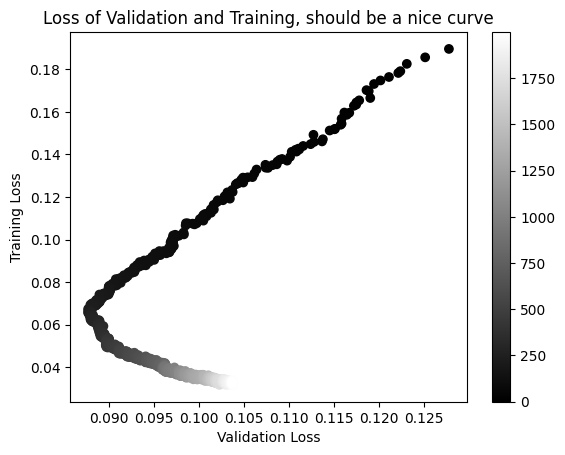

In [166]:
plt.scatter(numpy_e_trainer.val_costs,numpy_e_trainer.train_epoch_costs,c=epoch_count, cmap='gray')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()

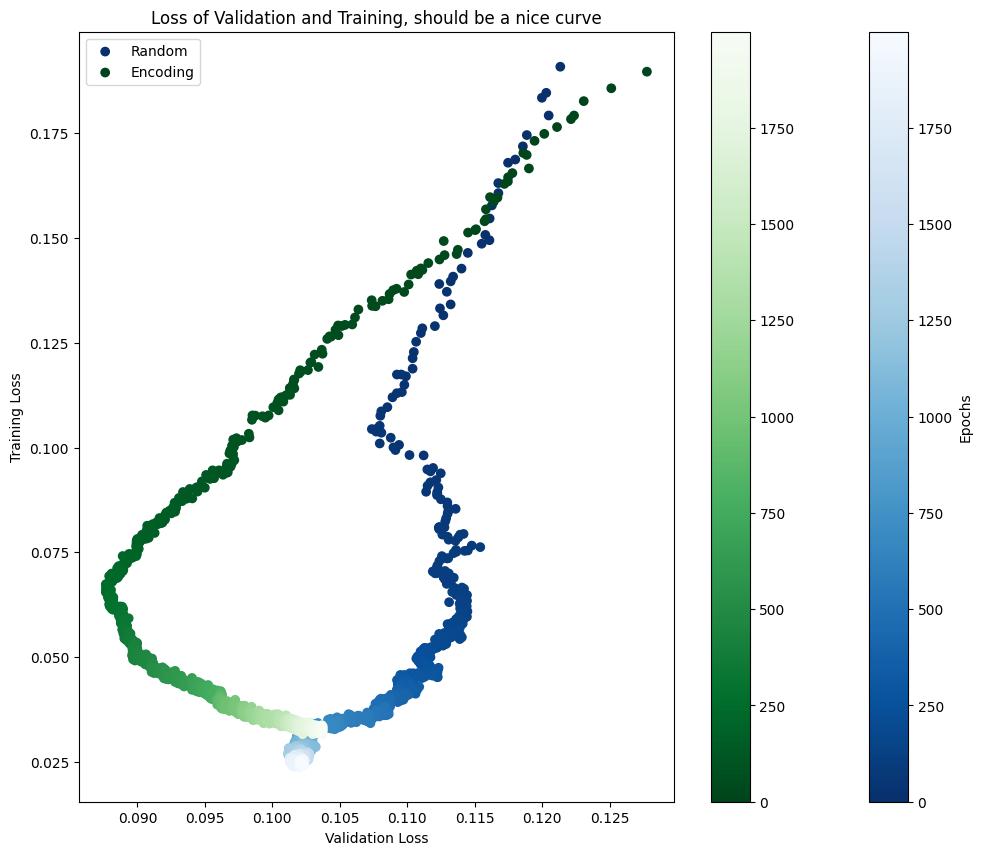

In [186]:
ax = plt.figure(figsize=(12,10))
plt.scatter(numpy_trainer.val_costs,numpy_trainer.train_epoch_costs,c=epoch_count, cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(numpy_e_trainer.val_costs,numpy_e_trainer.train_epoch_costs,c=epoch_count, cmap='Greens_r', label = 'Encoding')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()
plt.legend()

In [212]:
random_prediction = pd.Series(numpy_model.get_diagram_output(diagrams))
random_e_prediction = pd.Series(numpy_e_model.get_diagram_output(diagrams))

grouped_data['score'].corr(random_e_prediction, method='spearman'), grouped_data['score'].corr(random_prediction, method='spearman')

(-0.05285025645407524, -0.00622272222584045)

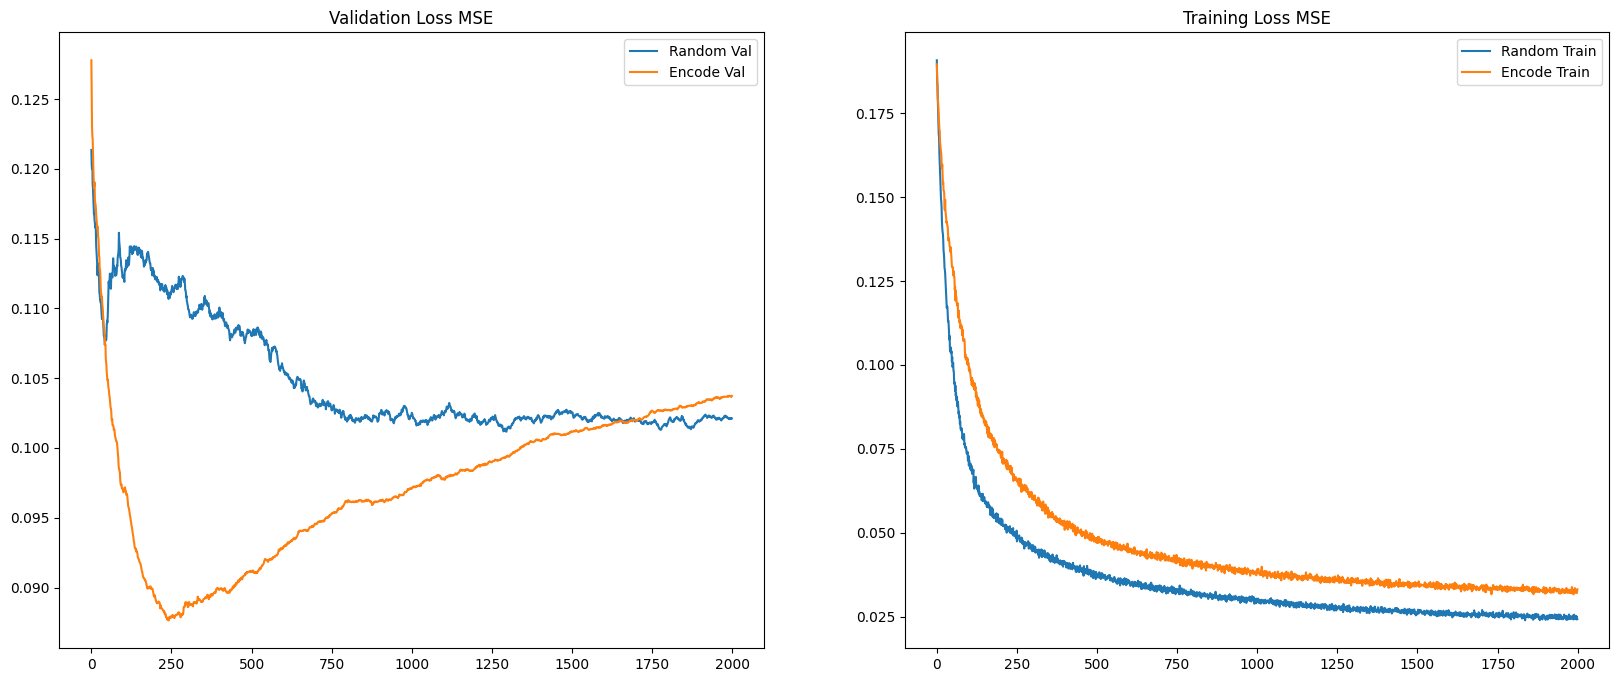

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.figsize=(30,15)

ax1.set_title("Validation Loss MSE")
ax1.plot(epoch_count, numpy_trainer.val_costs, label = 'Random Val')
ax1.plot(epoch_count, numpy_e_trainer.val_costs, label = 'Encode Val')
ax1.legend()

ax2.set_title("Training Loss MSE")
ax2.plot(epoch_count, numpy_trainer.train_epoch_costs, label = 'Random Train')
ax2.plot(epoch_count, numpy_e_trainer.train_epoch_costs, label = 'Encode Train')
ax2.legend()


## Repeating for lower EPOCHS:

In [242]:
EPOCHS = 300

from lambeq import QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss

numpy_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
mse = MSELoss()

numpy_trainer = QuantumTrainer(
    numpy_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)
numpy_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1906   valid/loss: 0.1205   train/mse: 0.1910   valid/mse: 0.1205
Epoch 100:  train/loss: 0.0722   valid/loss: 0.1142   train/mse: 0.0726   valid/mse: 0.1142
Epoch 200:  train/loss: 0.0534   valid/loss: 0.1140   train/mse: 0.0550   valid/mse: 0.1140
Epoch 300:  train/loss: 0.0463   valid/loss: 0.1106   train/mse: 0.0455   valid/mse: 0.1106

Training completed!


In [243]:
mse = MSELoss()

numpy_e_trainer = QuantumTrainer(
    numpy_e_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)
numpy_e_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1888   valid/loss: 0.1277   train/mse: 0.1879   valid/mse: 0.1277
Epoch 100:  train/loss: 0.0948   valid/loss: 0.0976   train/mse: 0.0957   valid/mse: 0.0976
Epoch 200:  train/loss: 0.0713   valid/loss: 0.0931   train/mse: 0.0733   valid/mse: 0.0931
Epoch 300:  train/loss: 0.0584   valid/loss: 0.0921   train/mse: 0.0583   valid/mse: 0.0921

Training completed!


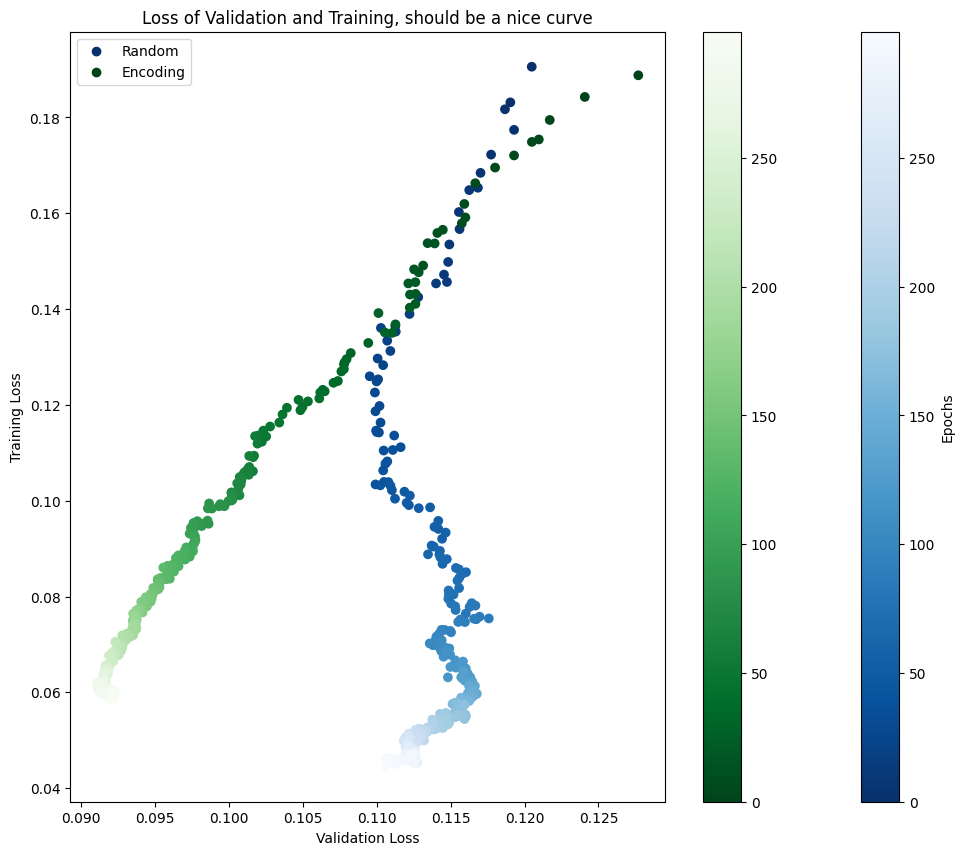

In [244]:
ax = plt.figure(figsize=(12,10))
plt.scatter(numpy_trainer.val_costs,numpy_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(numpy_e_trainer.val_costs,numpy_e_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Greens_r', label = 'Encoding')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()
plt.legend()

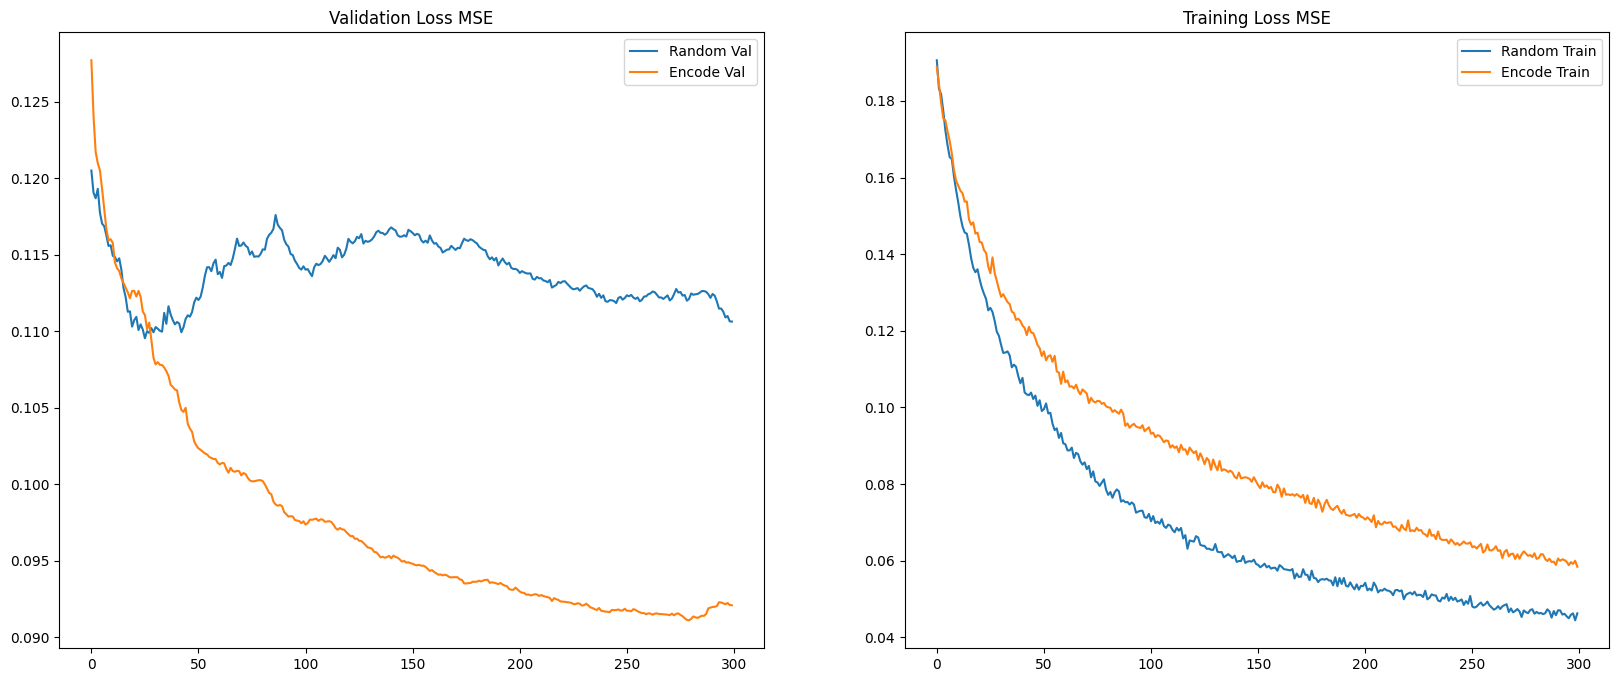

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.figsize=(30,15)

ax1.set_title("Validation Loss MSE")
ax1.plot(range(EPOCHS), numpy_trainer.val_costs, label = 'Random Val')
ax1.plot(range(EPOCHS), numpy_e_trainer.val_costs, label = 'Encode Val')
ax1.legend()

ax2.set_title("Training Loss MSE")
ax2.plot(range(EPOCHS), numpy_trainer.train_epoch_costs, label = 'Random Train')
ax2.plot(range(EPOCHS), numpy_e_trainer.train_epoch_costs, label = 'Encode Train')
ax2.legend()


## Pennylane Model

In [45]:
pennylane_model = PennyLaneModel.from_diagrams(diagrams, normalize=False)

pennylane_model.initialise_weights()

Can quantum computers learn sentence embeddings from dimensionality-reduced, classically-learnt word embeddings using the DisCoCat framework? 

In [46]:
def custom_cosine(y_hat, y):
    a_y_hat = y_hat.reshape(-1,1)
    a_y = y.reshape(-1,1)
    return torch.nn.functional.cosine_similarity(a_y_hat, a_y)
	#return torch.nn.functional.cosine_embedding_loss(a_y_hat, a_y)

pennylane_trainer = PytorchTrainer(
    model=pennylane_model,
    loss_function=torch.nn.functional.mse_loss, #
    optimizer=torch.optim.SGD , # Use SPSA, SGD
    learning_rate=2.5,
    epochs=EPOCHS,
    evaluate_functions={'mse': torch.nn.functional.mse_loss,'l1_loss':torch.nn.functional.l1_loss, 'poisson_nll':torch.nn.functional.poisson_nll_loss},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

pennylane_trainer.fit(train_dataset, val_dataset, logging_step=15)

Epoch 1:    train/loss: 0.1870   valid/loss: 0.1198   train/mse: 0.1870   train/l1_loss: 0.3565   train/poisson_nll: 1.0241   valid/mse: 0.1198   valid/l1_loss: 0.2768   valid/poisson_nll: 1.0380
Epoch 15:   train/loss: 0.1295   valid/loss: 0.1096   train/mse: 0.1295   train/l1_loss: 0.2863   train/poisson_nll: 1.0665   valid/mse: 0.1096   valid/l1_loss: 0.2531   valid/poisson_nll: 1.0571
Epoch 30:   train/loss: 0.1284   valid/loss: 0.1074   train/mse: 0.1284   train/l1_loss: 0.2810   train/poisson_nll: 1.0720   valid/mse: 0.1074   valid/l1_loss: 0.2485   valid/poisson_nll: 1.0611
Epoch 45:   train/loss: 0.1268   valid/loss: 0.1087   train/mse: 0.1268   train/l1_loss: 0.2783   train/poisson_nll: 1.0733   valid/mse: 0.1087   valid/l1_loss: 0.2498   valid/poisson_nll: 1.0607
Epoch 60:   train/loss: 0.1270   valid/loss: 0.1093   train/mse: 0.1270   train/l1_loss: 0.2778   train/poisson_nll: 1.0743   valid/mse: 0.1093   valid/l1_loss: 0.2545   valid/poisson_nll: 1.0559
Epoch 75:   train/lo

In [47]:
epoch_count = [i for i in range(0, EPOCHS)]
len(epoch_count)

300

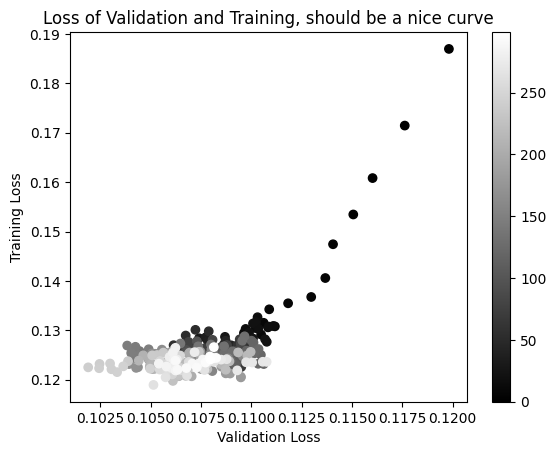

In [48]:
plt.scatter(trainer.val_costs,trainer.train_epoch_costs, c = epoch_count, cmap='gray')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()

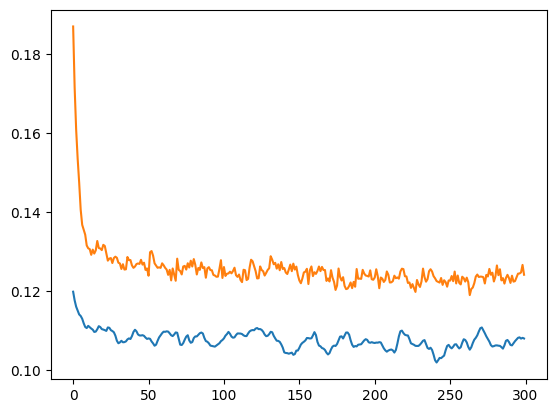

In [49]:
plt.plot(epoch_count, trainer.val_costs)
plt.plot(epoch_count, trainer.train_epoch_costs)

# My Encoding

In [ ]:
class ClassicalUploadPennyLaneModel(PennyLaneModel):
    def initialise_weights(self, vector) -> None:
        """Initialise the weights of the model.
        Parameters
        ----------
        vector : list or numpy.ndarray or torch.Tensor
            1D array of numbers between [0-1] to be used as weights.
        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.
        """
        self._reinitialise_modules()
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                             '`PennyLaneModel.from_diagrams()`.')

        vector_tensor = torch.tensor(vector).squeeze()
        self.weights = torch.nn.ParameterList([
            torch.nn.Parameter(value)
            for value in vector_tensor
        ])
        for p_circ in self.circuit_map.values():
            p_circ.initialise_concrete_params(self.symbols, self.weights)


labels = grouped_data['score']

train_data =  [make_circuit_from_data(training, i)[1] for i in range(len(training))]#diagrams[: int(0.7*number_of_data)]
train_labels = labels[training['Unnamed: 0'].values]
val_data = [make_circuit_from_data(test, i)[1] for i in range(len(test))] #diagrams[int(0.7*number_of_data):]
val_labels = labels[test['Unnamed: 0'].values]

diagrams = train_data + val_data

train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

model = ClassicalUploadPennyLaneModel.from_diagrams(diagrams, normalize=False)

model.initialise_weights(vector)

In [ ]:
#Making the encoding vector:
qubits_per_word = 4
total_qubits = 3 * qubits_per_word
row = 0
vector = np.zeros(shape=(len(make_circuit_from_data(training, 0)[1].free_symbols), len(training)))
print(vector)
for row in range(0, len(grouped_data)):
	vector[0:2, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
	vector[2:8, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
	vector[8:10, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']
	vector[10:12, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
	vector[14:20, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
	vector[12:14, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']

for row in range(0, len(grouped_data)):
    subject_size = len(word_vector_dict[training['subject'+str(1)][row]]['pca_2'])
    verb_size = len(word_vector_dict[training['verb'+str(1)][row]]['pca_6'])
    object_size = len(word_vector_dict[training['object'+str(1)][row]]['pca_2'])
    
    vector[0:subject_size, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
    vector[subject_size:subject_size+verb_size, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
    vector[subject_size+verb_size:subject_size+verb_size+object_size, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']
    vector[subject_size+verb_size+object_size:subject_size+verb_size+object_size+subject_size, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
    vector[subject_size+verb_size+object_size+subject_size+2:subject_size+verb_size+object_size+subject_size+verb_size+2, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
    vector[subject_size+verb_size+object_size+subject_size+verb_size+2:subject_size+verb_size+object_size+subject_size+verb_size+object_size+2, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


ValueError: could not broadcast input array from shape (6,) into shape (2,)

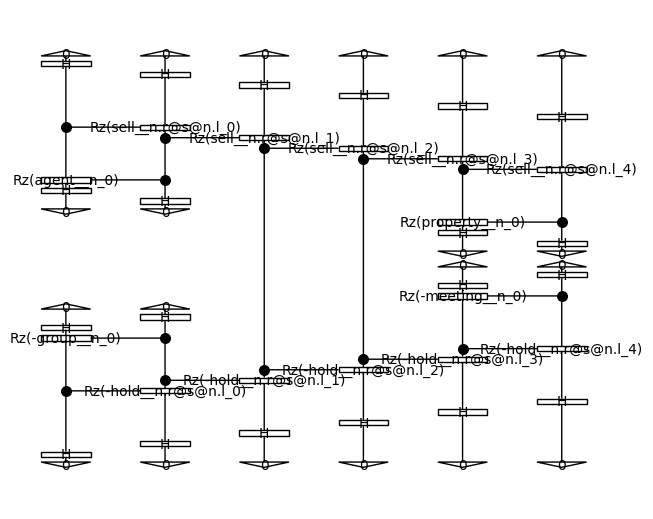

In [ ]:
make_circuit_from_data(grouped_data, 1)[1].draw(figsize=(6,5))

In [ ]:
# CHATGOT:

labels = grouped_data['score']
sentences1 = [grouped_data['subject'+str(1)], grouped_data['verb'+str(1)], grouped_data['object'+str(1)]]
sentences2 = [grouped_data['subject'+str(1)], grouped_data['verb'+str(1)], grouped_data['object'+str(1)]]

diagrams = [make_circuit_from_data(i)[1] for i in range(len(grouped_data))]

number_of_data = len(diagrams)
train_data = diagrams[: int(0.7*number_of_data)]
train_labels = labels[: int(0.7*number_of_data)]
val_data = diagrams[int(0.7*number_of_data):]
val_labels = labels[int(0.7*number_of_data):]

train_dataset = Dataset(train_data, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

model = PennyLaneModel.from_diagrams(diagrams, normalize=False)
model.initialise_weights()

def custom_cosine(y_hat, y):
    a_y_hat = y_hat.reshape(-1,1)
    a_y = y.reshape(-1,1)
    return torch.nn.functional.cosine_similarity(a_y_hat, a_y)

loss_function = torch.nn.functional.mse_loss
learning_rate = 1.0
evaluate_functions = {'mse': torch.nn.functional.mse_loss, 'l1_loss': torch.nn.functional.l1_loss, 'poisson_nll': torch.nn.functional.poisson_nll_loss}
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(EPOCHS):
    # Training loop
    model.train()
    total_loss = 0
    for data, labels in train_dataset:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_train_loss = total_loss / len(train_dataset)

    # Validation loop
    model.eval()
    total_val_loss = 0
    for data, labels in val_dataset:
        with torch.no_grad():
            output = model(data)
            val_loss = loss_function(output, labels)
            total_val_loss += val_loss.item()
    average_val_loss = total_val_loss / len(val_dataset)

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {average_train_loss}, Val Loss = {average_val_loss}")

    # Additional evaluation functions
    for eval_name, eval_func in evaluate_functions.items():
        train_eval = eval_func(model(train_dataset.data), train_dataset.labels)
        val_eval = eval_func(model(val_dataset.data), val_dataset.labels)
        print(f"Epoch {epoch + 1}/{EPOCHS}: Train {eval_name} = {train_eval}, Val {eval_name} = {val_eval}")

TypeError: 'int' object is not callable